In [1]:
%config IPCompleter.greedy=True
import warnings
import sys
warnings.filterwarnings(action='ignore')

### data wrangling and plotting tools
import pandas as pd
import numpy as np
import matplotlib as mlb
import matplotlib.pyplot as plt
import mpl_toolkits.axes_grid.inset_locator as mpl_il
from operator import itemgetter
import seaborn as sns
from scipy.stats import norm
import operator
from functools import reduce

### machine learning algorithms and measurement tools
from sklearn.model_selection import train_test_split, validation_curve, cross_val_score, cross_val_predict
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso, LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.metrics import precision_recall_curve, roc_curve, confusion_matrix, f1_score

In [2]:
### Sets fontsize while plotting in whole notebook
font = {'size': 20}
mlb.rc('font', **font)

In [3]:
### Use customized color palette
colors = {'green': '#1CCE28' , 'lightgreen': '#66E86E', 'lightgreen1': '#00FF00', 'darkolivegreen': '#347849', \
            'lightolivegreen': '#BFDC80', 'olivegreen': '#6E8D25', 'darkgray': '#5D5D5C', 'gray': '#78909C', \
            'lightgray': '#B6B6B6', 'darkbluegray': '#266478', 'bluegray': '#3B8985', 'lightbluegray': '#86C0CF', \
            'black': '#000000', 'white': '#FFFFFF', 'red': '#FF0000', 'blue': '#0000FF', 'yellow': '#FFFF00'}


# Data loading and preparation
First of all we load the real-estate data for munich. This data was obtained by web-scraping a real-estate website with an R-script. The data itself and the R-script are not included in this project due to unclear rights.

In [3]:
### Load dataset and drop unnecessary column
filename = "flatrent_munich_2019-02-27_13-26-23.csv"
dataset_date = filename[16:26]
#df = pd.read_csv("../datasets/immo/"+filename, engine='python')
#df.drop(['Unnamed: 0', 'flatID', 'title', 'location'], axis=1, inplace=True)

#print(df.isna().sum())
#df.head()

In [5]:
### Keep only those flats, where some inventory is specified 
df = df.dropna(subset=['Inventar'])
print(df.count(), df.isna().sum())

flatID              1327
title               1327
location            1327
rent                1327
area                1327
rooms               1327
Nebenkosten         1327
Heizkosten          1327
Gesamtmiete         1327
Kaution             1234
Miete Stellplatz     670
Baujahr             1163
Objektzustand        982
Heizungsart          984
Bezugsdatum         1269
Inventar            1327
dtype: int64 flatID                0
title                 0
location              0
rent                  0
area                  0
rooms                 0
Nebenkosten           0
Heizkosten            0
Gesamtmiete           0
Kaution              93
Miete Stellplatz    657
Baujahr             164
Objektzustand       345
Heizungsart         343
Bezugsdatum          58
Inventar              0
dtype: int64


## Data cleaning
The first step is to clean the scraped data, because real world data has many flaws. We have to remove unnecessary currency strings from prices and convert them to a numeric data type. Furthermore we replace the comma by a dot in all numbers in order to convert them. We compute the total rent (Gesamtmiete neu) by adding base rent and side costs as well as costs for heating. Then we create new features like the total rent per square meter including side costs (Quadratmeterpreis warm) as well as only the rent without heating and side costs (Quadratmeterpreis kalt).

In [6]:
### Convert strings to numbers and clean strings from underscores and double whitespaces
df['location'] = df['location'].str.replace("_", " ")
df['location'] = df['location'].str.replace("  ", " ")
df['rooms'] = df['rooms'].str.replace(",", ".")
df['rooms'] = df['rooms'].astype(np.float64)
df['Nebenkosten'] = df['Nebenkosten'].str.replace(',', '.')
df['Nebenkosten'] = df['Nebenkosten'].str.replace('[ €+]', '')
df['Nebenkosten'] = pd.to_numeric(df['Nebenkosten'], errors='coerce')
df['Heizkosten'] = df['Heizkosten'].str.replace('[ +€]+', '')
df['Heizkosten'] = df['Heizkosten'].str.replace('inkl.', '')

### replace Heizkosten by either NaN or 0 whether they are not specified or they are included in Nebenkosten
df['Heizkosten'] = df['Heizkosten'].str.replace('nichtinNebenkostenenthalten|keineAngabe', 'NaN')
df['Heizkosten'] = df['Heizkosten'].str.replace('inNebenkostenenthalten', '0')
df['Heizkosten'] = df['Heizkosten'].str.replace(',', '.')
df['Heizkosten'] = pd.to_numeric(df['Heizkosten'], errors='coerce')
df['Miete Stellplatz'] = df['Miete Stellplatz'].str.replace('[ €+]', '')
df['Miete Stellplatz'] = df['Miete Stellplatz'].str.replace(',', '.')
df['Miete Stellplatz'] = pd.to_numeric(df['Miete Stellplatz'], errors='coerce')
df['Baujahr'] = pd.to_datetime(df['Baujahr'], errors='coerce', format='%Y').dt.year
#### Bezugsdatum could be used in the future -> replace 'ab sofort' with dataset_date (use: .str.contains(thisstring))
df.drop(['Bezugsdatum'], axis=1, inplace=True) 

#### Create Gesamtmiete neu by adding up all costs: future: could double check this calculated value with Gesamtmiete in dataset
split = df['Gesamtmiete'].str.split('€')
df['miete'] = pd.Series(map(itemgetter(0), split))
df['miete'] = df['miete'].str.replace('.', '')
df['miete'] = df['miete'].str.replace(',', '.')
df['miete'] = pd.to_numeric(df['miete'].str.replace(' ', ''), errors='coerce')

### Create new features
df['Gesamtmiete neu'] = df['miete'] + df['Nebenkosten'] + df['Heizkosten']
df['Quadratmeterpreis kalt'] = df['rent']/df['area']
df['Quadratmeterpreis warm'] = df['Gesamtmiete neu']/df['area']

### this columns could be used in the future: Kaution
df.drop(['miete', 'Gesamtmiete'], axis=1, inplace=True)
df.rename(columns={'rent':'Kaltmiete', 'area': 'Fläche', 'title': 'Name', 'location': 'Adresse', \
                   'Gesamtmiete neu': 'Gesamtmiete', 'rooms':'Zimmer'}, inplace=True)

print(df.isna().sum())
df.head()


flatID                      0
Name                        0
Adresse                     0
Kaltmiete                   0
Fläche                      0
Zimmer                      0
Nebenkosten               203
Heizkosten                137
Kaution                    93
Miete Stellplatz          657
Baujahr                   231
Objektzustand             345
Heizungsart               343
Inventar                    0
Gesamtmiete               343
Quadratmeterpreis kalt      0
Quadratmeterpreis warm    343
dtype: int64


,Kaltmiete,Fläche,Zimmer,Nebenkosten,Heizkosten,Kaution,Miete Stellplatz,Baujahr,Objektzustand,Heizungsart,Inventar,Gesamtmiete,Quadratmeterpreis kalt,Quadratmeterpreis warm
0,5700.0,225.80,6.0,495.0,0.0,"17.100,00 EUR",125.0,1900.0,Neuwertig,Fernwärme,Balkon/ Terrasse Keller Personenaufzug Einbau...,6690.0,25.243578,29.627989
1,1380.0,54.00,2.0,270.0,0.0,6500,NaN,NaN,Erstbezug nach Sanierung,Zentralheizung,Balkon/ Terrasse Einbauküche,1920.0,25.555556,35.555556
2,1770.0,52.00,2.0,NaN,0.0,NaN,NaN,NaN,Neuwertig,Etagenheizung,Balkon/ Terrasse Keller Personenaufzug Einbau...,NaN,34.038462,NaN
3,1908.0,106.00,3.5,300.0,0.0,3.816,NaN,1963.0,Gepflegt,Zentralheizung,Balkon/ Terrasse Keller Einbauküche Garten/ -...,2508.0,18.000000,23.660377
4,2350.0,121.44,3.0,240.0,120.0,NaN,75.0,2017.0,Neuwertig,Fußbodenheizung,Balkon/ Terrasse Keller Personenaufzug Einbau...,3070.0,19.351120,25.279974


Here we create columns for each mentioned inventory of the flat, where each flat possessing the specified inventory is marked with True, while flats missing the inventory are marked as False.

In [7]:
df['Inventar'] = df['Inventar'].str.replace('/ ', '/')
df['Inventar'] = df['Inventar'].str.replace('Stufenloser Zugang', 'Stufenloser-Zugang')
df['Inventar'] = df['Inventar'].str.replace('Wohnberechtigungsschein erforderlich', 'Wohnberechtigungsschein-erforderlich')
test = df['Inventar']
test = test.str.split(" ").tolist()
test = pd.Series(reduce(operator.concat, test))
#print(test.unique())
for col in test.unique():
    if col != '':
        df[col] = df.apply(lambda x: True if col in x['Inventar'] else False, axis=1)
df.drop(['Inventar'], axis=1, inplace=True)
#df[[x for x in test.unique()[1:]] + ['Inventar']].head()
df.head()


,Kaltmiete,Fläche,Zimmer,Nebenkosten,Heizkosten,Kaution,Miete Stellplatz,...,Quadratmeterpreis warm,Balkon/Terrasse,Keller,Personenaufzug,Einbauküche,Garten/-mitbenutzung,Gäste-WC,Stufenloser-Zugang,WG-geeignet,Wohnberechtigungsschein-erforderlich
0,5700.0,225.80,6.0,495.0,0.0,"17.100,00 EUR",125.0,...,29.627989,True,True,True,True,True,True,True,False,False
1,1380.0,54.00,2.0,270.0,0.0,6500,NaN,...,35.555556,True,False,False,True,False,False,False,False,False
2,1770.0,52.00,2.0,NaN,0.0,NaN,NaN,...,NaN,True,True,True,True,False,False,False,False,False
3,1908.0,106.00,3.5,300.0,0.0,3.816,NaN,...,23.660377,True,True,False,True,True,False,True,True,False
4,2350.0,121.44,3.0,240.0,120.0,NaN,75.0,...,25.279974,True,True,True,True,False,True,False,False,False


Create a label, whether the corresponding flat is in the top 20% of highest rents or in the cheapest 20% of all flats.

In [8]:
### Create a label whether a flat is in the top x % of the cheapest or most expensive flats
percentage = 0.2

sorting = df[['flatID', 'Quadratmeterpreis kalt']]
sorting_cheap = sorting.sort_values(by=['Quadratmeterpreis kalt'])
sorting_exp = sorting.sort_values(by=['Quadratmeterpreis kalt'], ascending=False)
sorting_cheap = sorting_cheap.head(int(len(sorting_cheap)*percentage))
sorting_exp = sorting_exp.head(int(len(sorting_exp)*percentage))
ID_list = sorting_cheap['flatID'].unique()
ID_list_exp = sorting_exp['flatID'].unique()
df['cheapest {0:.0f}%'.format(percentage*100)] = df.apply(lambda x: 1 if x['flatID'] in ID_list else 0, axis=1)
df['most expensive {0:.0f}%'.format(percentage*100)] = df.apply(lambda x: 1 if x['flatID'] in ID_list_exp else 0, axis=1)


In [9]:
df_kalt = df.drop(['Nebenkosten', 'Heizkosten', 'Gesamtmiete', 'Miete Stellplatz', 'Quadratmeterpreis warm'], axis=1).copy()
#df_kalt.isna().sum()
#f.isna().sum()
df.count()


Kaltmiete                               1327
Fläche                                  1327
Zimmer                                  1327
Nebenkosten                             1124
Heizkosten                              1190
Kaution                                 1234
Miete Stellplatz                         670
Baujahr                                 1096
Objektzustand                            982
Heizungsart                              984
Gesamtmiete                              984
Quadratmeterpreis kalt                  1327
Quadratmeterpreis warm                   984
Balkon/Terrasse                         1327
Keller                                  1327
Personenaufzug                          1327
Einbauküche                             1327
Garten/-mitbenutzung                    1327
Gäste-WC                                1327
Stufenloser-Zugang                      1327
WG-geeignet                             1327
Wohnberechtigungsschein-erforderlich    1327
cheapest 2

## Data visualization and descriptive statistics

In [10]:
### Create longform of dataframe to use in boxplot
box = pd.melt(df[['Kaltmiete', 'Gesamtmiete']])
box1 = pd.melt(df[['Quadratmeterpreis kalt', 'Quadratmeterpreis warm']])
box1['variable'] = box1['variable'].str.replace('Quadratmeterpreis ', '')
#### Drop all flats without any Baujahr
box2 = pd.melt(df[['Fläche', 'Baujahr']].dropna())


### Statistics: All flats
From this statistic we see that the mean flat in munich has 2.5 rooms and costs about 35€ per square meter. The typical construction year is 1986. Due to some very expensive flats I think the median is much more appropriate to describe the average flat in munich, which gives a medium price of 27€ per square meter. We will see the price distribution of flats afterwards.

In [11]:
### Statistical measures
selector = ['Kaltmiete', 'Gesamtmiete', 'Fläche', 'Quadratmeterpreis kalt', 'Quadratmeterpreis warm', \
    'Zimmer', 'Baujahr']
df[selector].describe()


,Kaltmiete,Gesamtmiete,Fläche,Quadratmeterpreis kalt,Quadratmeterpreis warm,Zimmer,Baujahr
count,1327.000000,984.000000,1327.000000,1327.000000,984.000000,1327.000000,1096.000000
mean,1683.871070,2086.826758,76.693956,23.355009,35.004619,2.498493,1986.612226
std,925.917522,1007.253371,40.360578,7.406642,27.707940,1.069069,36.231097
min,150.000000,220.000000,11.000000,7.500000,2.209340,1.000000,1742.000000
25%,1100.000000,1468.750000,50.000000,18.048396,18.755755,2.000000,1968.000000
50%,1498.000000,1887.745000,73.000000,21.641791,27.200502,2.500000,1997.000000
75%,1996.000000,2466.250000,95.000000,27.343750,42.413759,3.000000,2018.000000
max,12000.000000,14060.000000,420.000000,65.000000,433.950617,8.000000,2019.000000


### Statistics: 20% cheapest flats
When comparing the cheapest flats with the average flat from above we see, that it is much larger. Thus a cheap flat could be found by focusing on larger flats. Then we get a medium price of about 16€ per square meter. However there might be no significant difference in the average construction year.

In [12]:
df[selector].where(df["cheapest {0:.0f}%".format(percentage*100)]==1).describe()

,Kaltmiete,Gesamtmiete,Fläche,Quadratmeterpreis kalt,Quadratmeterpreis warm,Zimmer,Baujahr
count,265.000000,228.000000,265.000000,265.000000,228.000000,265.000000,210.000000
mean,1428.004038,2133.959298,92.717811,15.434798,25.394651,2.971698,1980.014286
std,540.509966,991.187199,35.661016,1.635910,14.082144,0.917089,30.284216
min,150.000000,250.000000,15.000000,7.500000,4.823529,1.000000,1845.000000
25%,1090.000000,1502.500000,70.000000,14.583333,16.292879,2.000000,1965.000000
50%,1348.000000,1940.000000,85.000000,15.753425,22.639768,3.000000,1982.500000
75%,1646.760000,2574.500000,110.000000,16.666667,30.772845,3.500000,2002.000000
max,4000.000000,6900.000000,298.110000,17.409091,97.844583,6.500000,2019.000000


### Statistics: 20% most expensive flats
We see that expensive flats are much smaller than the average flat, only about 42 square meters large with one and a half rooms on average. This could result from the fact, that expensive flats are more often in the center of the city (there is not as much space as in the outer districts of the city). Furthermore there is a trend to newer flats in this case, which has to be proved statistically in a later study.

In [13]:
df[selector].where(df['most expensive {0:.0f}%'.format(percentage*100)]==1).describe()

,Kaltmiete,Gesamtmiete,Fläche,Quadratmeterpreis kalt,Quadratmeterpreis warm,Zimmer,Baujahr
count,265.00000,127.000000,265.000000,265.000000,127.000000,265.000000,221.000000
mean,1788.20717,2038.972756,53.025509,34.909174,62.656433,1.816981,1984.837104
std,1179.84448,1365.177532,36.650697,6.410562,48.885142,0.954204,38.523673
min,480.00000,220.000000,11.000000,28.915663,2.209340,1.000000,1742.000000
25%,990.00000,1471.000000,27.000000,30.746395,34.585987,1.000000,1968.000000
50%,1450.00000,1810.000000,42.630000,32.846715,52.368421,1.500000,1994.000000
75%,2400.00000,2210.500000,71.000000,36.585366,80.000000,2.500000,2016.000000
max,9800.00000,14060.000000,288.000000,65.000000,433.950617,5.000000,2019.000000


### Visualization: Price distribution

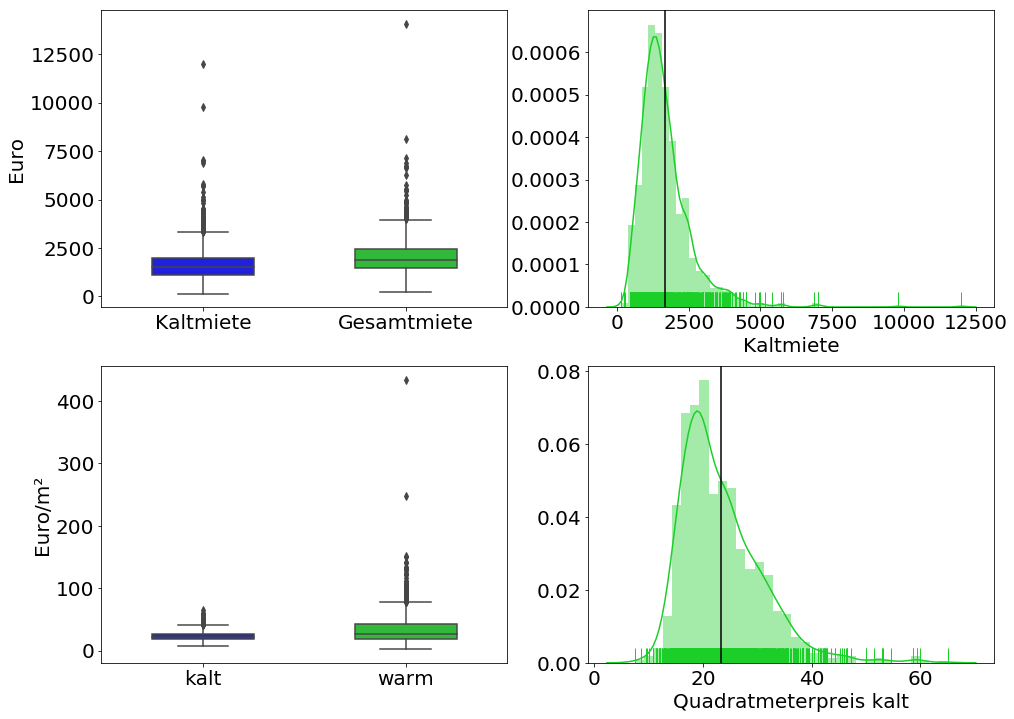

In [14]:
#with sns.plotting_context(font_scale=1.5):
mypal = {colors['green'], colors['blue']}

fig = plt.figure(figsize=(16,12));

################ Plots for Kaltmiete ##############
ax = fig.add_subplot(2,2,1)
ax = sns.boxplot(y="value", x="variable", data=box, width=0.5, palette=mypal);
ax.set_xlabel('')
ax.set_ylabel('Euro')

ax = fig.add_subplot(2,2,2)
ax = sns.distplot(df['Kaltmiete'], rug=True, color=colors['green']);
ax.axvline(df['Kaltmiete'].describe()['mean'], color=colors['black']);

######### Plots for Quadratmeterpreis kalt ###################
ax = fig.add_subplot(2,2,3)
ax = sns.boxplot(y="value", x="variable", data=box1, width=0.5, palette=mypal);
ax.set_xlabel('')
ax.set_ylabel('Euro/m²')

ax = fig.add_subplot(2,2,4)
ax = sns.distplot(df['Quadratmeterpreis kalt'], rug=True, color=colors['green']);
ax.axvline(df['Quadratmeterpreis kalt'].describe()['mean'], color=colors['black']);

#### Fit gaussian distribution
#ax = sns.distplot(df['Kaltmiete'], fit=norm, kde=False, color=colors['green'])

#bplot = sns.swarmplot(x="variable", y="value", data=data, color=".25")


Here we see, what we discussed shortly in the descriptive statistics part. We have outliers in the upper price range, which can be huge, while there are very rare outliers at the bottom price range (cheaper flats). This suggests to use the median instead of the mean for discussing average flats.

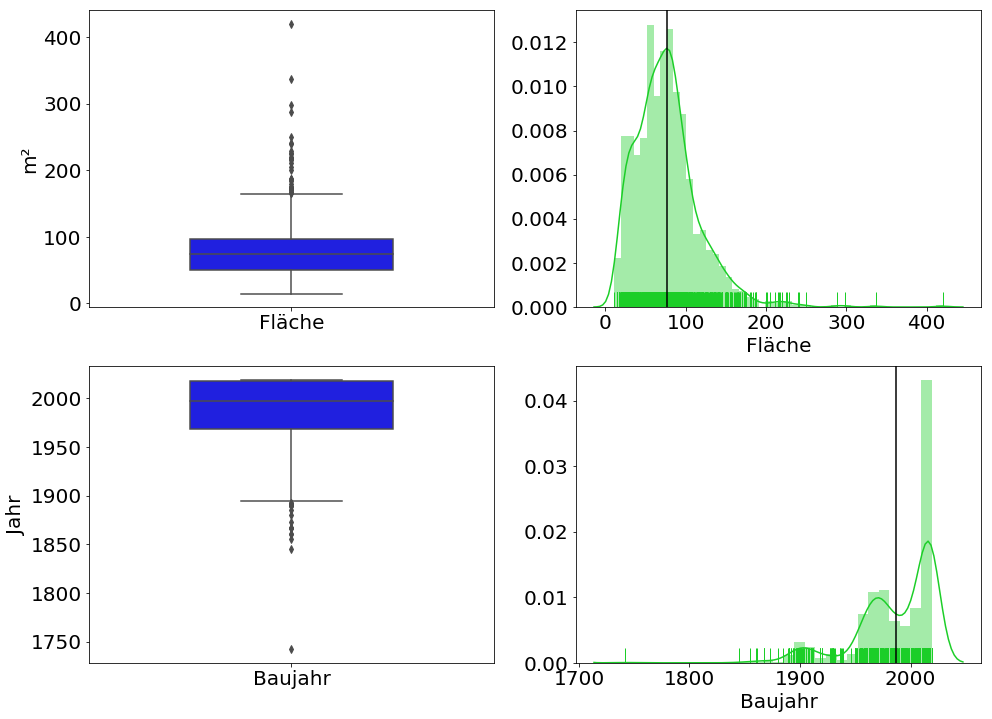

In [15]:
fig = plt.figure(figsize=(16,12));

########## Plot for Fläche #####################
ax = fig.add_subplot(2,2,1)
ax = sns.boxplot(x="variable", y='value', data=box2.where(box2['variable']=='Fläche'), width=0.5, palette=mypal)
ax.set_xlabel('')
ax.set_ylabel('m²')
ax = fig.add_subplot(2,2,2)
ax = sns.distplot(df['Fläche'], rug=True, color=colors['green']);
ax.axvline(df['Fläche'].describe()['mean'], color=colors['black']);
########## Plot for Baujahr ####################
ax = fig.add_subplot(2,2,3)
ax = sns.boxplot(x="variable", y='value', data=box2.where(box2['variable']=='Baujahr'), width=0.5, palette=mypal)
ax.set_xlabel('')
ax.set_ylabel('Jahr')
ax = fig.add_subplot(2,2,4)
ax = sns.distplot(df['Baujahr'].dropna(), rug=True, color=colors['green']);
ax.axvline(df['Baujahr'].describe()['mean'], color=colors['black']);


The same result can be seen for the flat area. We have a lot of huge outliers in the upper range, which are huge flats with corresponding huge prices. The construction year peaks at the 2000ers as well as in the 1970s.

## Inventory
As a next step we want to look at the typical inventory of a munich flat. 

In [25]:
classes = df[['Objektzustand', 'Heizungsart', 'Fläche']].dropna()
zustand = classes.groupby(by='Objektzustand').count()
zustand.drop('Heizungsart', axis=1, inplace=True)
zustand.rename(columns={'Fläche':''}, inplace=True)
heizung = classes.groupby(by='Heizungsart').count()
heizung.drop('Objektzustand', axis=1, inplace=True)
heizung.rename(columns={'Fläche':''}, inplace=True)

# fig = plt.figure(figsize=(28,12))

# ax = plt.subplot2grid((2,2), (0,0))

# #zustand.plot.pie(subplots=True, figsize=(5,5), legend=False, fontsize=10)
# plt.pie(np.array(zustand), labels=zustand.index, startangle=90, textprops={'fontsize':20})
# centre_circle = plt.Circle((0,0),0.55,fc='white')

# fig = plt.gcf()
# fig.gca().add_artist(centre_circle)
# ax.axis('equal')
# plt.title('Zustand der Wohnung', fontsize=50)


# explode = tuple(0.05 for _ in range(len(heizung)))

# ax = plt.subplot2grid((2,2), (0,1))
# heizung.plot.pie(subplots=True, legend=False, figsize=(5,5), fontsize=10)
# #plt.pie(heizung, labels=heizung.index, startangle=0, explode=explode, textprops={'fontsize':20})
# ax.axis('equal')
# plt.title('Heizungsart', fontsize=50)


# ax1 = plt.subplot2grid((2,2), (1,0))
# x = zustand.index
# y = zustand[''].tolist()
# zus = plt.bar(x, y, color=colors['green'])
# #ax.ticklabel_format(fontsize=20)
# ax1.set_xlabel('Objektzustand', fontsize=20)
# ax1.legend().remove
# for item in ax1.yaxis.get_ticklabels() + ax1.xaxis.get_ticklabels():
#     item.set_rotation(45)
#     item.set_fontsize(20)
# ### Remove all frames and x-axis
# ax1.spines['right'].set_visible(False)
# ax1.spines['top'].set_visible(False)
# ax1.spines['left'].set_visible(False)
# ax1.spines['bottom'].set_visible(False)
# #ax1.yaxis.set_visible(False)
# ax1.set_ylabel('Anzahl', fontsize=20)
# ax1.set_yticklabels([])
# for j in range(len(x)):
#     ax1.text(x[j], y[j]+5, str(y[j]), fontsize=20)
    

    

# ax2 = plt.subplot2grid((2,2), (1,1))
# heizung.plot.barh(ax=ax2, color=olors['green'])
# ax2.set_ylabel('', fontsize=20)
# ax2.set_xlabel('Anzahl', fontsize=20)
# ax2.legend().remove
# for item in ax2.yaxis.get_ticklabels() + ax2.xaxis.get_ticklabels():
#     item.set_rotation(45)
#     item.set_fontsize(20)
# #### remove all frames
# ax2.spines['right'].set_visible(False)
# ax2.spines['top'].set_visible(False)


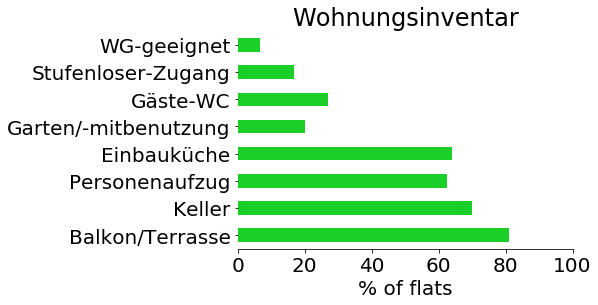

In [26]:
inventory = df[['Name', 'Balkon/Terrasse', 'Keller', 'Personenaufzug', 'Einbauküche', 'Garten/-mitbenutzung', \
                'Gäste-WC', 'Stufenloser-Zugang', 'WG-geeignet']].copy()
inv_data = inventory.describe().T
inv_data.drop(['unique'], axis=1, inplace=True)
inv_data.drop(['Name'], axis=0, inplace=True)
inv_data['percentage'] = inv_data.apply(lambda x: x['freq']/x['count']*100 if x['top']==True else (x['count']-x['freq'])/x['count']*100, axis=1)
inv_data = inv_data['percentage']

fig = plt.figure();
ax = inv_data.plot.barh(color=colors['green']);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlim(0,100);
ax.set_xlabel("% of flats");
ax.set_title("Wohnungsinventar");


Most of the flats seem to have either a balcony or a terasse. A cellar, an elevator and a built-in kitchen are also very common. We conclude further, that the flats posted on this real-estate site can not be used as shared-apartments in most of the cases (WG-geeignet).

Now let's have a look at the most useful features for predicting the price of a flat. 

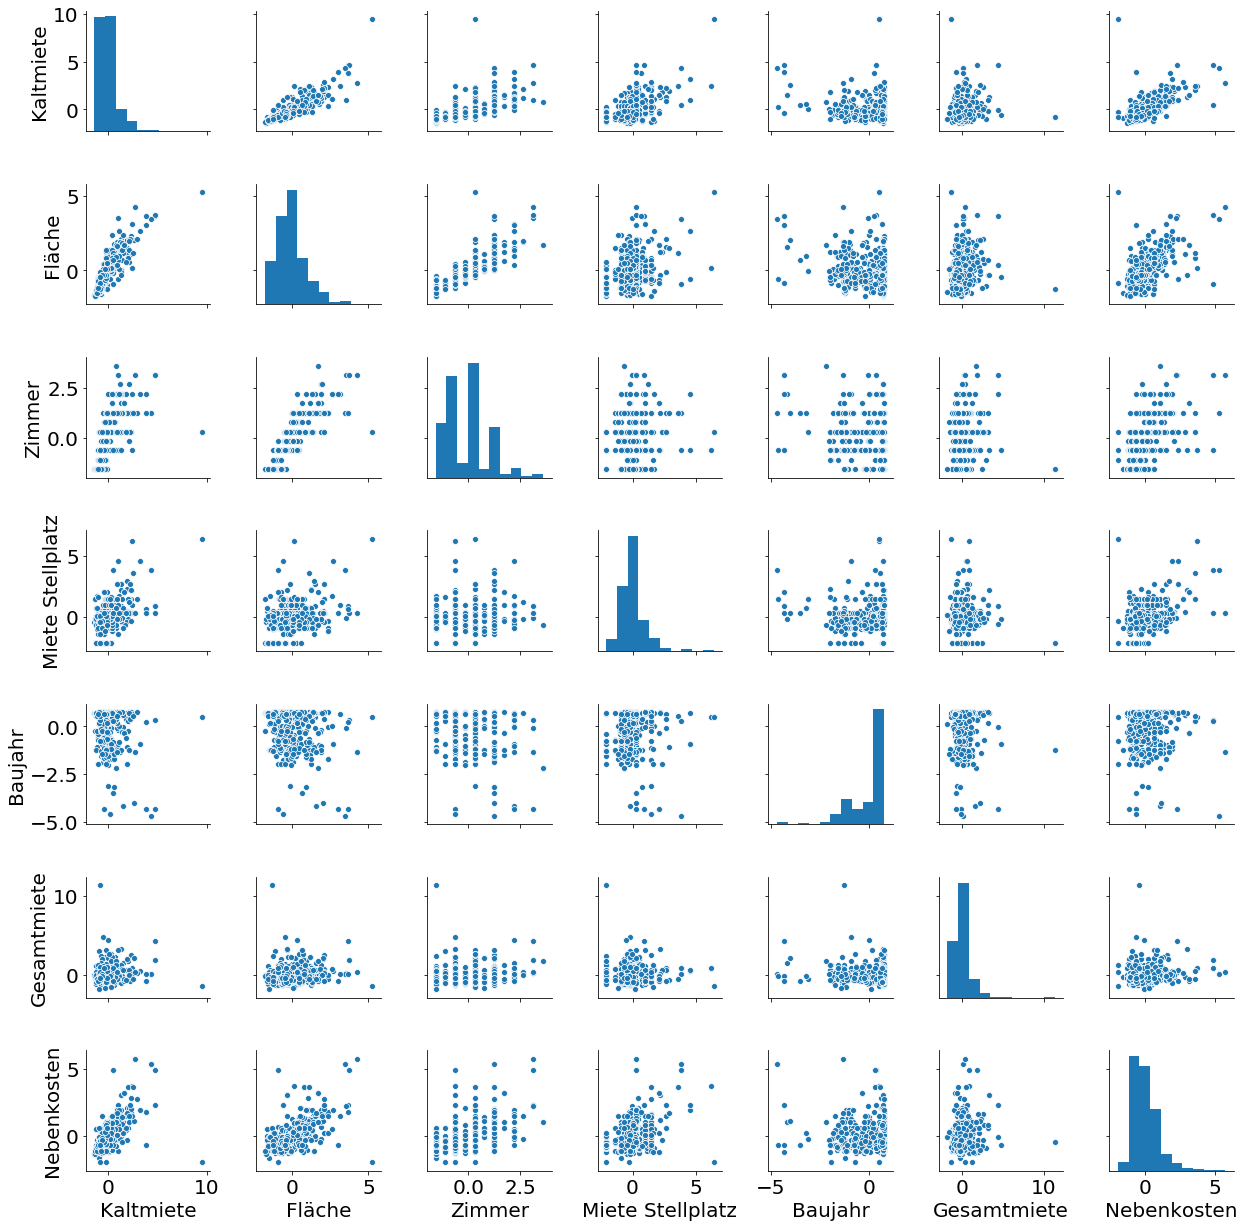

In [27]:
corrs = df[['Kaltmiete', 'Fläche', 'Zimmer', 'Miete Stellplatz', 'Baujahr', 'Gesamtmiete', 'Nebenkosten']].copy()
corrs.dropna(inplace=True)
norm_corrs = (corrs - corrs.mean())/corrs.std()

g = sns.pairplot(norm_corrs)


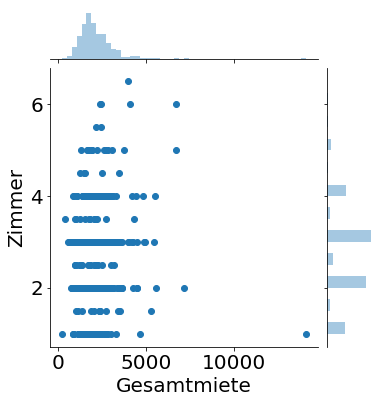

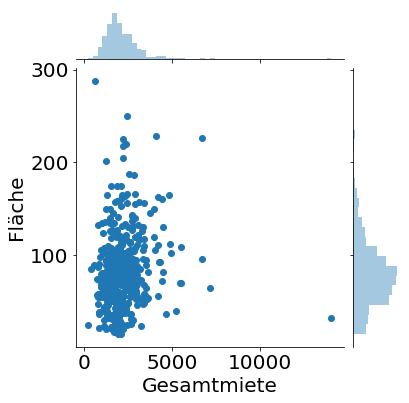

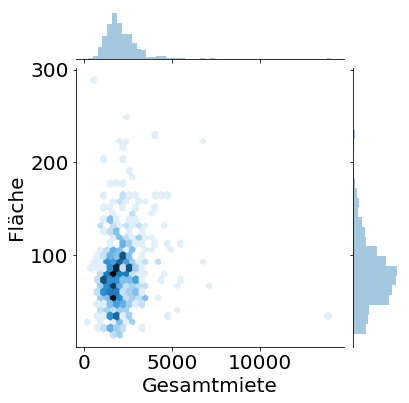

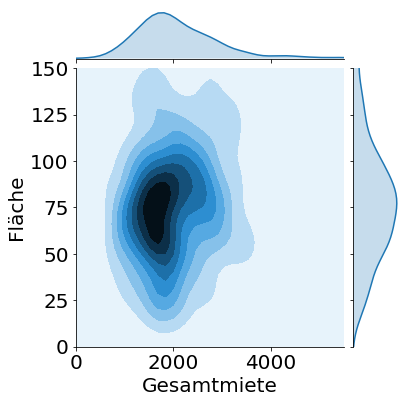

In [28]:
sns.jointplot(corrs['Gesamtmiete'], corrs['Zimmer']);
sns.jointplot(corrs['Gesamtmiete'], corrs['Fläche']);
ax1 = sns.jointplot(corrs['Gesamtmiete'], corrs['Fläche'], kind='hex');
ax2 = sns.jointplot(corrs['Gesamtmiete'], corrs['Fläche'], kind='kde');
ax2.ax_marg_x.set_xlim(0,5500);
ax2.ax_marg_y.set_ylim(0,150);


These plots give us a very good understanding of the correlation between total rent and flat area. The distribution is a bit skewed to larger prices as well as to larger flats.
To further elaborate on this behaviour we bin each datapoint into one of three categories for area and construction year. Then we have a look at the distribution of total rent for each of the different categories by looking at the swarm- and violin-plots:

In [29]:
cor = corrs[['Gesamtmiete', 'Baujahr', 'Fläche']]
cor2 = corrs[['Fläche', 'Gesamtmiete']]
bins = pd.IntervalIndex.from_tuples([(cor['Baujahr'].min(), 1950), (1950, 2000), (2000, cor['Baujahr'].max())])
epoch = pd.cut(cor['Baujahr'], bins, labels=['historic', 'old', 'modern'])
area = pd.cut(cor['Fläche'], 3, labels=['small', 'mid-size', 'large'])
cor['Bauepoche'] = epoch
cor['Wohnungsgröße'] = area
df['Bauepoche'] = epoch
df['Wohnungsgröße'] = area
cor.count()


Gesamtmiete      507
Baujahr          507
Fläche           507
Bauepoche        506
Wohnungsgröße    507
dtype: int64

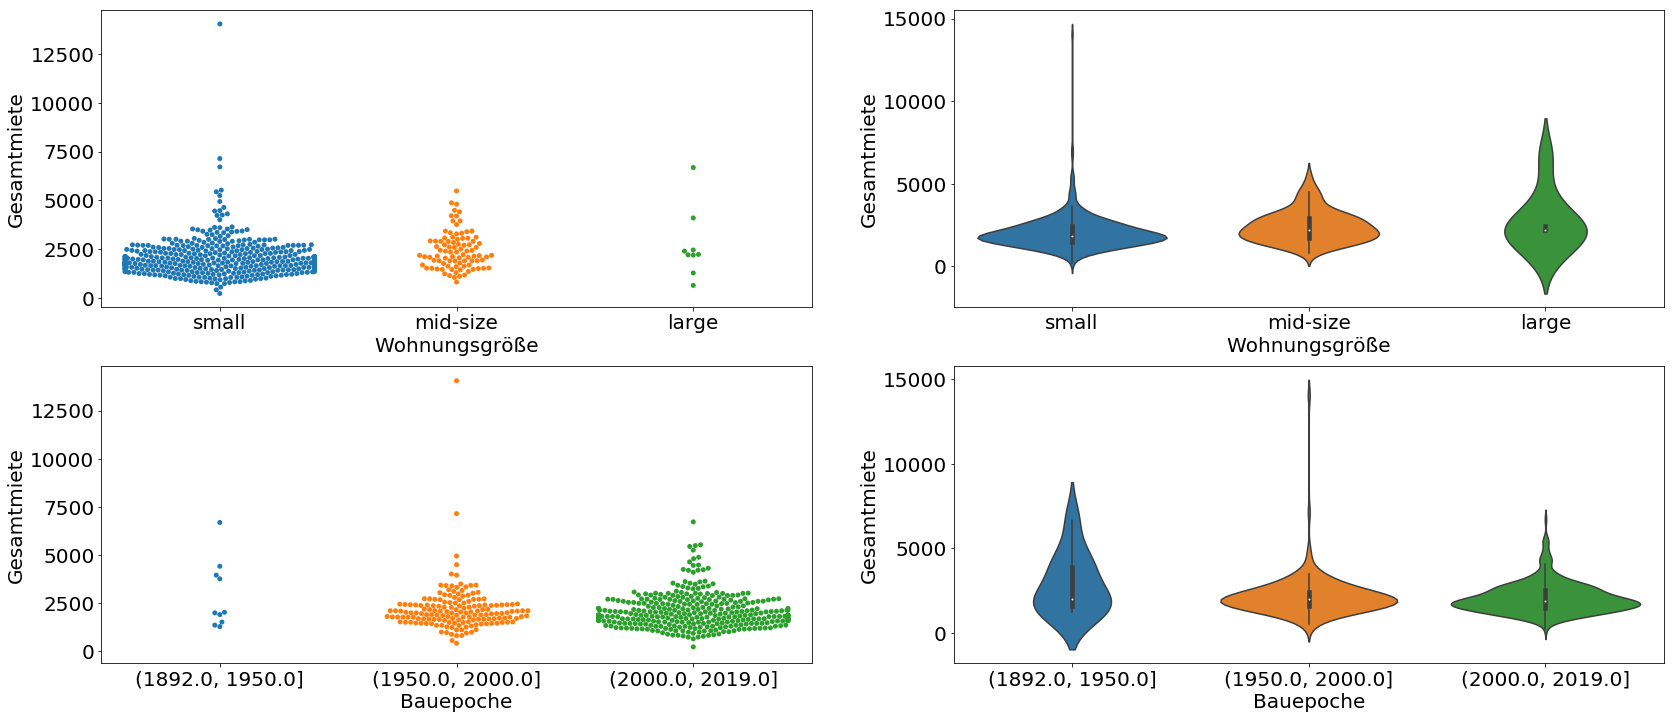

In [30]:
fig = plt.figure(figsize=(28,12));

ax = plt.subplot2grid((2,2), (0,0))
ax = sns.swarmplot('Wohnungsgröße', 'Gesamtmiete', data=cor);
ax = plt.subplot2grid((2,2), (0,1))
ax = sns.violinplot('Wohnungsgröße', 'Gesamtmiete', data=cor);

ax = plt.subplot2grid((2,2), (1,0))
ax = sns.swarmplot('Bauepoche', 'Gesamtmiete', data=cor);
ax = plt.subplot2grid((2,2), (1,1))
ax = sns.violinplot('Bauepoche', 'Gesamtmiete', data=cor);


We see indeed that smaller flats are the ones with big outliers, while for medium sized flats there are very few outliers. Larger flats have some more expensive flats, because of course they are larger. Most of the flats seem to be in a price region of roughly 2500€. Looking at the distribution of construction year, we see that beside some outlier in the middle epoche, the oldest flats tend to be somewhat more expensive, having no cheap examples.

C:\Progra~1\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
C:\Progra~1\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
C:\Progra~1\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
C:\Progra~1\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


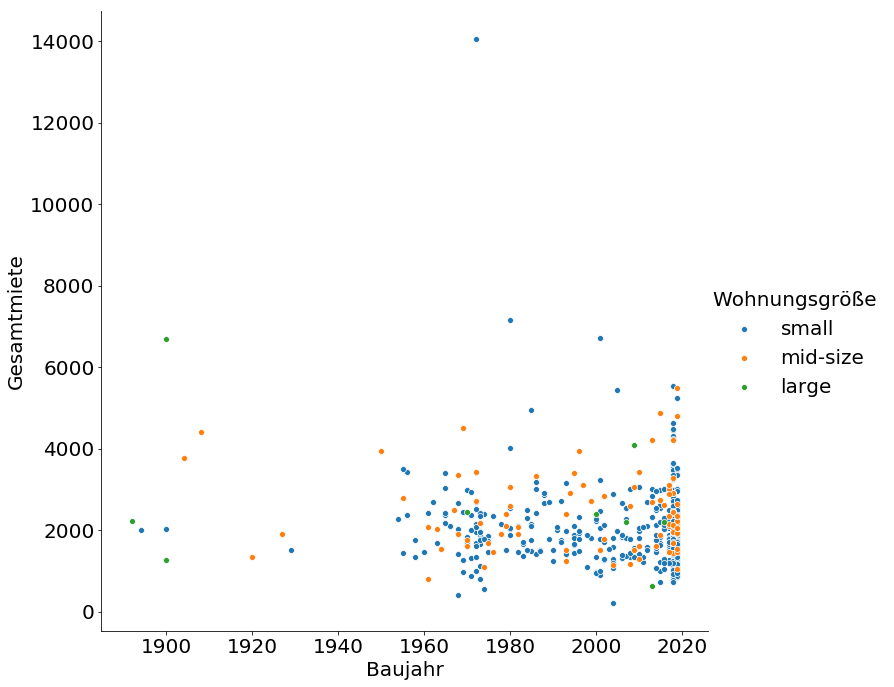

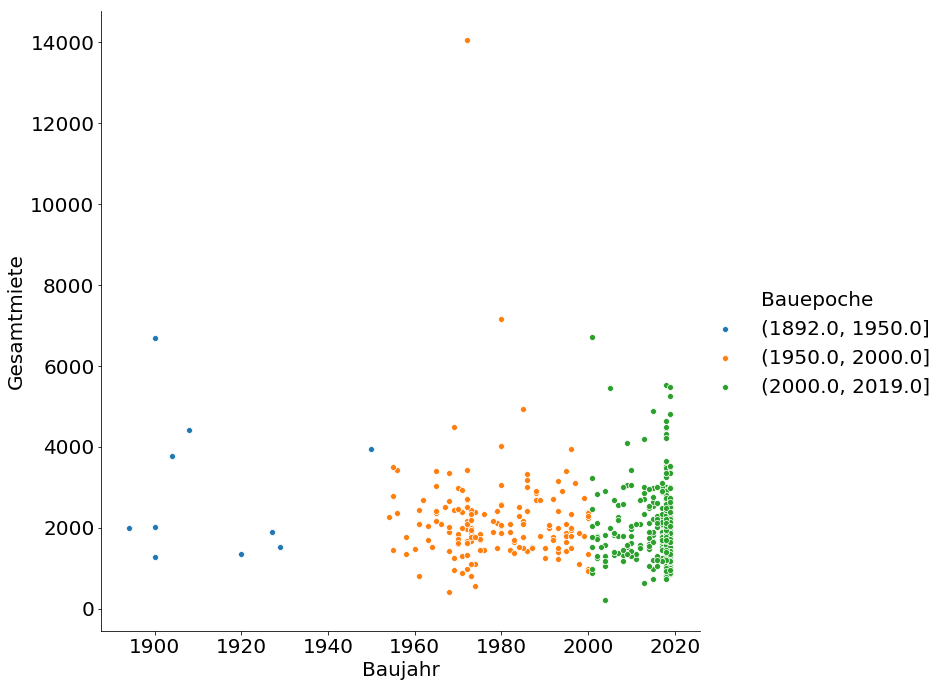

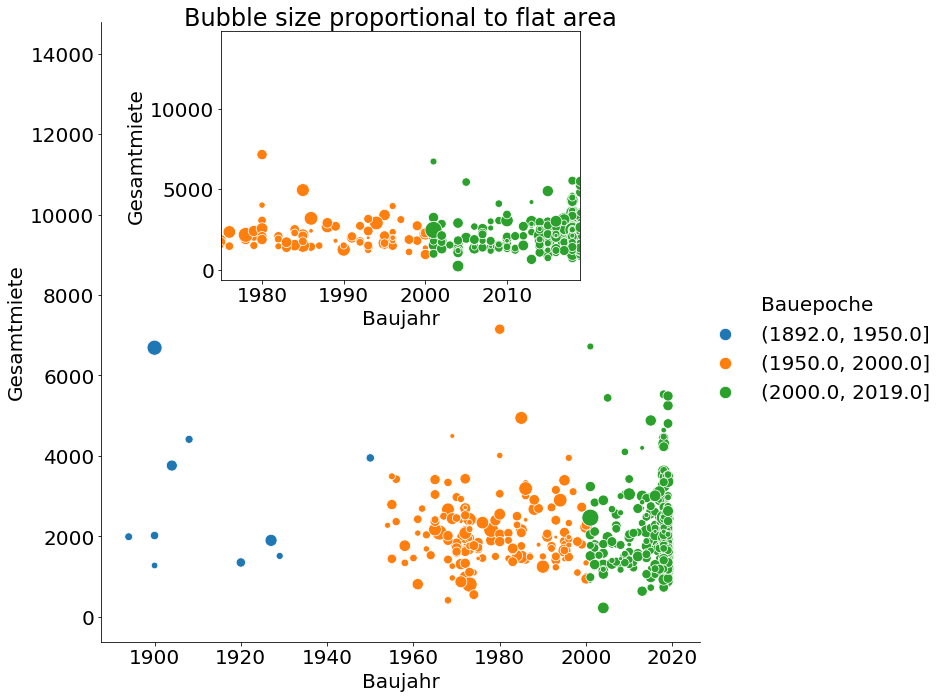

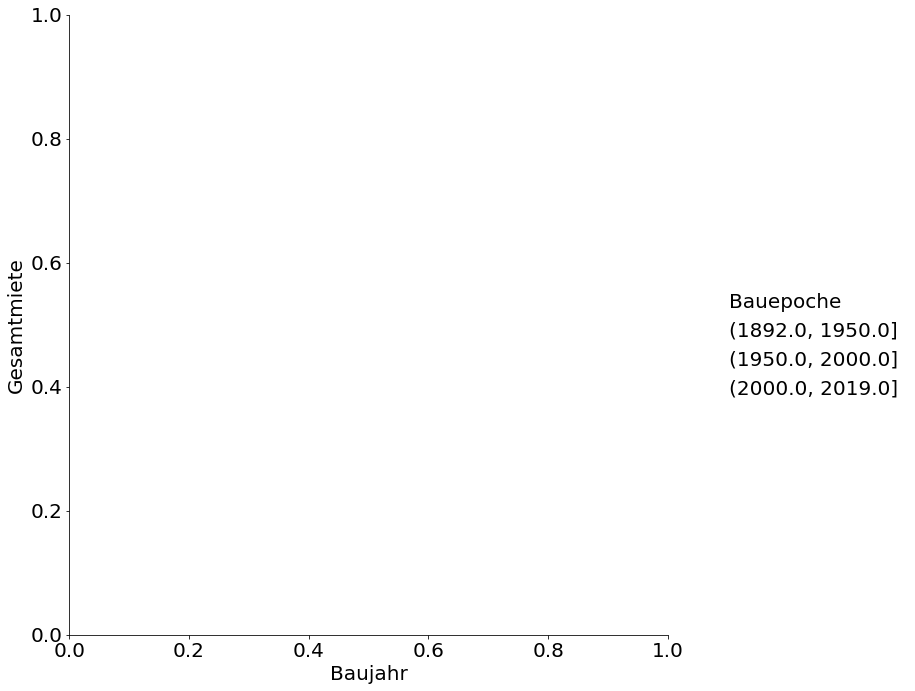

In [31]:
groups = cor.groupby('Bauepoche')

cs = [colors['yellow'], colors['green'], colors['red']]

#fig = plt.figure(figsize=(28,12));

#ax1 = plt.subplot2grid((2,2), (0,0))
#ax1 = plt.plot(0.5, 0.5, marker='o')
ax1 = sns.pairplot(x_vars=['Baujahr'], y_vars=['Gesamtmiete'], data = cor, hue='Wohnungsgröße', size=10);

#fig = plt.figure(figsize=(28,12));
#ax2 = plt.subplot2grid((2,2), (0,1))
ax2 = sns.pairplot(x_vars=['Baujahr'], y_vars=['Gesamtmiete'], data = cor, hue='Bauepoche', size=10);

#fig = plt.figure(figsize=(28,12));
#ax2 = plt.subplot2grid((2,2), (1,1))
ax3 = sns.pairplot(x_vars=['Baujahr'], y_vars=['Gesamtmiete'], data = cor, hue='Bauepoche', \
                   size=10, plot_kws={"s": cor['Fläche']});
ax4 = mpl_il.inset_axes(plt.gca(), width='60%', height='40%', loc=9);
sns.pairplot(x_vars=['Baujahr'], y_vars=['Gesamtmiete'], data = cor, hue='Bauepoche', \
                   size=10, plot_kws={"s": cor['Fläche'], "ax":ax4});
ax4.set_xlim(1975, 2019);
ax4.legend().set_visible(False);
ax4.set_title('Bubble size proportional to flat area');


The behaviour of these two groups compared to the price is summarized again in this bubble plot, where the size of the point indicates the age of the flat.

## Predict flat price
Here I try to predict the flat price based on the area, construction year and inventory. This is only a first version and should be improved further.

In [59]:
### Drop irrelevant features
adf = df.drop(['flatID', 'Name', 'Adresse', 'Kaution', 'Bauepoche','Wohnungsgröße', 'Heizungsart', 'Objektzustand'], axis=1)
adf.drop(['Kaltmiete', 'Nebenkosten', 'Heizkosten', 'Miete Stellplatz',\
         'Quadratmeterpreis warm', 'Gesamtmiete'], axis=1, inplace=True)
adf.dropna(inplace=True)
#df.set_index('flatID', inplace=True)
adf.head(n=30)
#adf.count()


,Fläche,Zimmer,Baujahr,Quadratmeterpreis kalt,Balkon/Terrasse,Keller,Personenaufzug,Einbauküche,Garten/-mitbenutzung,Gäste-WC,Stufenloser-Zugang,WG-geeignet,Wohnberechtigungsschein-erforderlich,cheapest 20%,most expensive 20%
0,225.80,6.0,1900.0,25.243578,True,True,True,True,True,True,True,False,False,0,0
3,106.00,3.5,1963.0,18.000000,True,True,False,True,True,False,True,True,False,0,0
4,121.44,3.0,2017.0,19.351120,True,True,True,True,False,True,False,False,False,0,0
5,49.90,2.0,2018.0,20.000000,True,True,True,False,False,False,True,False,False,0,0
6,25.00,1.0,1984.0,23.800000,True,False,False,False,False,False,False,False,False,0,0
8,69.92,3.0,1966.0,22.454233,True,True,True,True,False,False,False,False,False,0,0
9,82.00,2.0,2017.0,23.048780,True,False,False,True,False,False,False,False,False,0,0
10,64.75,2.0,2017.0,12.000000,True,True,True,True,False,False,True,False,True,1,0
11,145.00,5.0,1904.0,20.551724,True,True,False,False,False,False,False,False,False,0,0
12,28.00,1.0,1977.0,30.357143,True,True,True,True,True,False,True,False,False,0,1


### Linear Regression: Prediction using area
Here I only use the area of the flat in order to predict the price per square meter without heating costs.

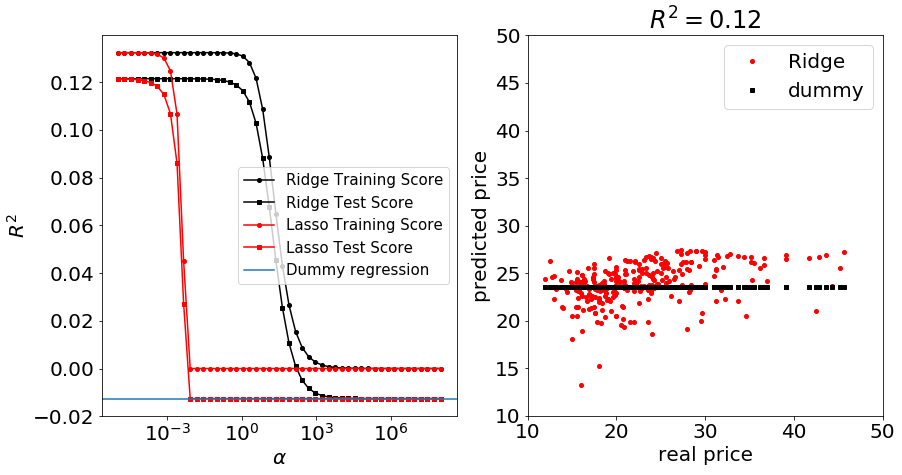

In [52]:
seed = 0
X = adf.drop(['cheapest {0:.0f}%'.format(percentage*100), 'most expensive {0:.0f}%'.format(percentage*100), \
              'Quadratmeterpreis kalt'], axis=1)
X = X[['Fläche']]
y = adf['Quadratmeterpreis kalt']
#y = adf['cheapest {0:.0f}%'.format(percentage*100)]
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=seed)

scalerx = MinMaxScaler()
scalery = MinMaxScaler()
x_train_scaled = scalerx.fit_transform(x_train)
x_test_scaled = scalerx.transform(x_test)
y_train_scaled = np.squeeze(scalery.fit_transform(np.array(y_train).reshape(-1,1)))
y_test_scaled = np.squeeze(scalery.transform(np.array(y_test).reshape(-1,1)))
#x_train_scaled = x_train
#x_test_scaled = x_test


alphas = np.logspace(-5, 8)
e_ridge = np.zeros((2, len(alphas)))
e_lasso = np.zeros((2, len(alphas)))
e_kridge = np.zeros((2, len(alphas)))

for i, alpha in enumerate(alphas):

    linridge = Ridge(alpha=alpha).fit(x_train_scaled, y_train_scaled)
    linlasso = Lasso(alpha=alpha, max_iter=10000).fit(x_train_scaled, y_train_scaled)
    #kerridgge = KernelRidge(alpha=alpha, kernel='rbf').fit(x_train_scaled, y_train_scaled)
    
    e_ridge[0][i] = linridge.score(x_train_scaled, y_train_scaled)
    e_ridge[1][i] = linridge.score(x_test_scaled, y_test_scaled)
    e_lasso[0][i] = linlasso.score(x_train_scaled, y_train_scaled)
    e_lasso[1][i] = linlasso.score(x_test_scaled, y_test_scaled)
    #e_kridge[0][i] = kerridgge.score(x_train_scaled, y_train_scaled)
    #e_kridge[1][i] = kerridgge.score(x_test_scaled, y_test_scaled)

plt.figure(figsize=(14,7)) 

ax = plt.subplot(1,2,1)
ax.semilogx(alphas, e_ridge[0], 'ko-', label="Ridge Training Score", ms=4)
ax.semilogx(alphas, e_ridge[1], 'ks-', label="Ridge Test Score", ms=4)
ax.semilogx(alphas, e_lasso[0], 'ro-', label="Lasso Training Score", ms=4)
ax.semilogx(alphas, e_lasso[1], 'rs-', label="Lasso Test Score", ms=4)
#ax.semilogx(alphas, e_kridge[0], 'go-', label="Kernel Ridge Training Score", ms=4)
#ax.semilogx(alphas, e_kridge[1], 'gs-', label="Kernel Ridge Test Score", ms=4)

clf = DummyRegressor(strategy='mean')
clf.fit(x_train_scaled, y_train_scaled)
dummy_score = clf.score(x_test_scaled, y_test_scaled)
plt.axhline(dummy_score, label="Dummy regression")

plt.xlabel("$\\alpha$")
plt.ylabel("$R^2$")
plt.legend(loc='best', prop = {'size':15})
#print(dummy_score)


ax = plt.subplot(1,2,2)
alpha = 0.0001
linridge = Ridge(alpha=alpha).fit(x_train_scaled, y_train_scaled)
y_predict = np.squeeze(scalery.inverse_transform(np.array(linridge.predict(x_test_scaled)).reshape(-1,1)))
y_predict_dummy = np.squeeze(scalery.inverse_transform(np.array(clf.predict(x_test_scaled)).reshape(-1,1)))

plt.plot(y_test, y_predict, 'ro', label="Ridge", ms=4);
plt.plot(y_test, y_predict_dummy, 'ks', label='dummy', ms=4);
plt.title("$R^2=$"+"{0:.2f}".format(linridge.score(x_test_scaled, y_test_scaled)))
plt.xlabel('real price');
plt.ylabel('predicted price');
plt.legend(loc=1);
plt.xlim(10,50)
plt.ylim(10,50);

Linear regression for Quadratmeterpreis kalt with 822 datapoints to train and 274 test data points

Linear Regression - Ridge

1 coefficients:  {'Fläche': -0.4869727032192618}
Number of non-zero coeffs =  1
Train score:  -10.466454791288006
Test score:  -10.379643173741828 


Linear Regression - Lasso

1 coefficients:  {'Fläche': -0.0}
Number of non-zero coeffs =  0
Train score:  -10.471650690248476
Test score:  -10.391560572567563


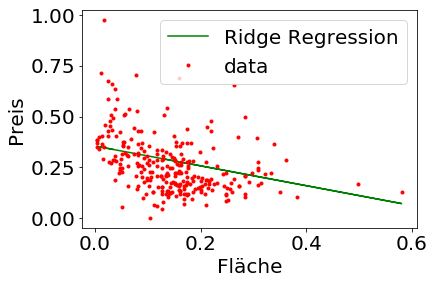

In [53]:
print("Linear regression for Quadratmeterpreis kalt with {} datapoints to train and {} test data points\n".format(len(y_train), len(y_test)))
print("Linear Regression - Ridge\n")
print(len(linridge.coef_), "coefficients: ", dict(zip(X.columns, linridge.coef_)))
print("Number of non-zero coeffs = ", np.sum(linridge.coef_!=0))
print("Train score: ", linridge.score(x_train_scaled, y_train))
print("Test score: ", linridge.score(x_test_scaled, y_test), "\n\n")

print("Linear Regression - Lasso\n")
print(len(linlasso.coef_), "coefficients: ", dict(zip(X.columns, linlasso.coef_)))
print("Number of non-zero coeffs = ", np.sum(linlasso.coef_!=0))
print("Train score: ", linlasso.score(x_train_scaled, y_train))
print("Test score: ", linlasso.score(x_test_scaled, y_test))

plt.plot(x_test_scaled, linridge.intercept_ + linridge.coef_*x_test_scaled, 'g-', label="Ridge Regression");
plt.plot(x_test_scaled, y_test_scaled, 'ro', ms=3, label="data");
plt.xlabel("Fläche");
plt.ylabel("Preis");
plt.legend(loc=1);



This result has to be improved significantly, because Lasso regularization does not work in this case. The Ridge regression gives a coefficient, but has somehow a negative score.

### Classification KNN: Predict if flat is cheap
Here we use all features (area, construction year, inventory) to predict, whether a flat is in the cheapest 20% of flats. For that purpose we split the data into train and test set and run a KNN nearest neighbor classifier on it.

In [61]:
seed = 0
X = adf.drop(['cheapest {0:.0f}%'.format(percentage*100), 'most expensive {0:.0f}%'.format(percentage*100), \
              'Quadratmeterpreis kalt'], axis=1)
#X = X[['Fläche']]
y = adf['cheapest {0:.0f}%'.format(percentage*100)]

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=seed)

scalerx = MinMaxScaler()
scalery = MinMaxScaler()
x_train_scaled = scalerx.fit_transform(x_train)
x_test_scaled = scalerx.transform(x_test)
y_train_scaled = np.squeeze(scalery.fit_transform(np.array(y_train).reshape(-1,1)))
y_test_scaled = np.squeeze(scalery.transform(np.array(y_test).reshape(-1,1)))

n = 25
print("KNN to predict if flat is cheap with {} datapoints to train and {} test data points\n".format(len(y_train), len(y_test)))

knn = KNeighborsClassifier(n_neighbors = n)
knn.fit(x_train, y_train)
print("KNN Classifier: n = {}\n".format(n))
print("Train score: ", knn.score(x_train, y_train))
print("Test score: ", knn.score(x_test, y_test), "\n\n")

knn.fit(x_train_scaled, y_train)
print("KNN Classifier with min-max scaled variables: n = {}\n".format(n))
print("Train score: ", knn.score(x_train_scaled, y_train))
print("Test score: ", knn.score(x_test_scaled, y_test))


KNN to predict if flat is cheap with 822 datapoints to train and 274 test data points

KNN Classifier: n = 25

Train score:  0.8272506082725061
Test score:  0.7737226277372263 


KNN Classifier with min-max scaled variables: n = 25

Train score:  0.8369829683698297
Test score:  0.7773722627737226


C:\Progra~1\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Progra~1\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


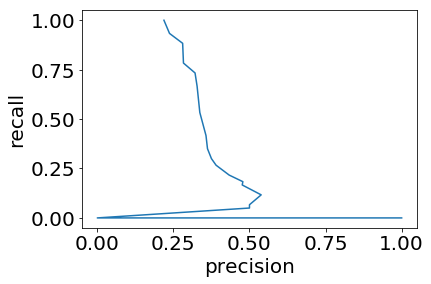

In [62]:
prediction = knn.predict_proba(x_test_scaled)
#prediction
#print(np.shape(y_test))
#print(np.shape(prediction))
precision, recall, threshold = precision_recall_curve(y_test, prediction[:,1])
plt.plot(precision, recall);
plt.xlabel("precision");
plt.ylabel("recall");


We get a test score of roughly 77%, which means we can predict whether a flat is in the cheapest 20% in 77% of the cases. The recall-precision curve seems a bit odd, this has to be elaborated further.
We want to push the test score further by hyper parameter tuning of the nearest neighbors to use for the classifier.

KNN to predict if flat is cheap with 822 datapoints to train and 274 test data points

KNN Classifier with min-max scaled variables: n = 1

Train score:  1.0
Test score:  0.7262773722627737
KNN Classifier with min-max scaled variables: n = 3

Train score:  0.889294403892944
Test score:  0.7554744525547445
KNN Classifier with min-max scaled variables: n = 5

Train score:  0.8552311435523114
Test score:  0.7700729927007299
KNN Classifier with min-max scaled variables: n = 7

Train score:  0.8467153284671532
Test score:  0.7664233576642335
KNN Classifier with min-max scaled variables: n = 9

Train score:  0.8442822384428224
Test score:  0.7554744525547445
KNN Classifier with min-max scaled variables: n = 11

Train score:  0.8418491484184915
Test score:  0.7554744525547445
KNN Classifier with min-max scaled variables: n = 13

Train score:  0.8357664233576643
Test score:  0.7773722627737226
KNN Classifier with min-max scaled variables: n = 15

Train score:  0.8406326034063261
Test score:  0

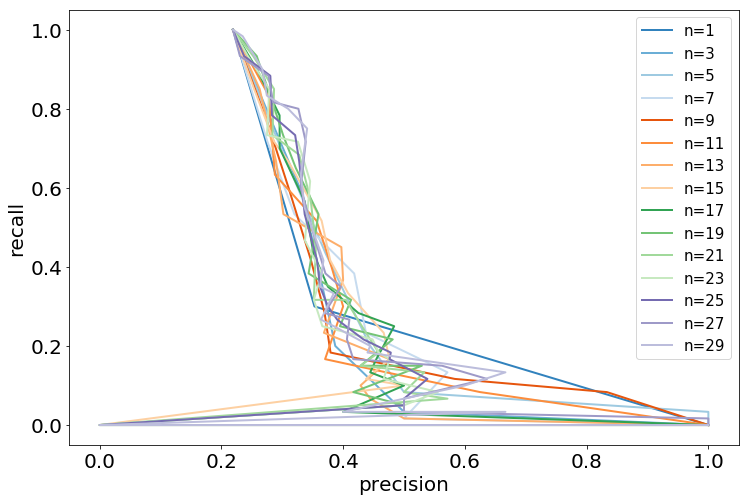

In [63]:
ns = np.arange(1,30,2)
color_palette = plt.get_cmap('tab20c')
print("KNN to predict if flat is cheap with {} datapoints to train and {} test data points\n".format(len(y_train), len(y_test)))

fig = plt.figure(figsize=(12,8))

for i, n in enumerate(ns):
    knn = KNeighborsClassifier(n_neighbors = n)
    #knn.fit(x_train, y_train)
    #print("KNN Classifier: n = {}\n".format(n))
    #print("Train score: ", knn.score(x_train, y_train))
    #print("Test score: ", knn.score(x_test, y_test), "\n\n")

    knn.fit(x_train_scaled, y_train)
    print("KNN Classifier with min-max scaled variables: n = {}\n".format(n))
    print("Train score: ", knn.score(x_train_scaled, y_train))
    print("Test score: ", knn.score(x_test_scaled, y_test))
    
    prediction = knn.predict_proba(x_test_scaled)
    precision, recall, threshold = precision_recall_curve(y_test, prediction[:,1])
    plt.plot(precision, recall, c=color_palette(i), label="n={}".format(n), linewidth=2);
plt.xlabel("precision");
plt.ylabel("recall");
plt.legend(loc=1, prop={'size':15});


It seems that the best score is produced with 29 neighbors. In the following we try a stratified sampling, which gives us a mean score of about 80%.

In [65]:
M = 10

x_m = X.as_matrix()
y_m = y.as_matrix()

cv_score = cross_val_score(knn, x_m, y_m, cv=M)
print("{}-fold stratified CV score: ".format(M), cv_score)
print("Mean of {}-fold CV score = ".format(M), np.mean(cv_score))

clf = DummyClassifier(strategy='most_frequent', random_state=0)
clf.fit(x_train_scaled, y_train)
y_pred = clf.predict(x_test_scaled)

print("\nF1 - Score of dummy classifier = ", f1_score(y_test, y_pred) )


10-fold stratified CV score:  [0.8        0.80909091 0.79090909 0.78181818 0.78181818 0.80909091
 0.80733945 0.80733945 0.78899083 0.81651376]
Mean of 10-fold CV score =  0.7992910758965805

F1 - Score of dummy classifier =  0.0


C:\Progra~1\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In the following we concentrate on the $F_1$ score, which is the harmonic mean of precision and recall. Here, we find the inverse picture to above: We should use a less number of neighbors to get the best results. This should be seen in the precision-recall curves, however they have to be done again.

C:\Progra~1\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Progra~1\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


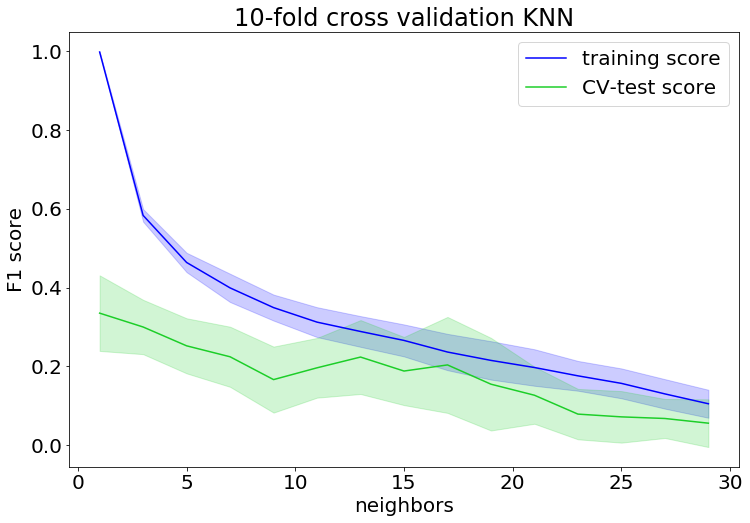

In [66]:
params = np.arange(1,31,2)
train_score, test_score = validation_curve(KNeighborsClassifier(), X, y, param_name="n_neighbors", \
                                           param_range=params, cv=M, scoring='f1', n_jobs=1)
train_mean = np.mean(train_score, axis=1)
train_std = np.std(train_score, axis=1)
test_mean = np.mean(test_score, axis=1)
test_std = np.std(test_score, axis=1)

fig = plt.figure(figsize=(12,8))
plt.plot(params, train_mean, c=colors['blue'], label='training score');
plt.fill_between(params, train_mean-train_std, train_mean+train_std, color=colors['blue'], alpha=0.2)
plt.plot(params, test_mean, c=colors['green'], label='CV-test score')
plt.fill_between(params, test_mean-test_std, test_mean+test_std, color=colors['green'], alpha=0.2)
#plt.ylim(0,1);
plt.xlabel("neighbors");
plt.ylabel("F1 score");
plt.title("{}-fold cross validation KNN".format(M));
plt.legend(loc=1);


### Classification: Decision Tree
As a last machine learning model we try a decision tree to predict whether a flat is cheap or not. We see that the best score is obtained by a small tree depth of a bit over 80%.

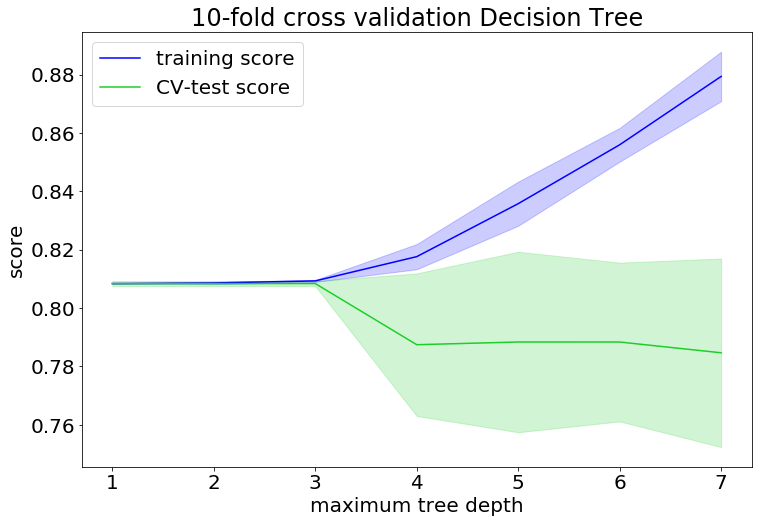

In [67]:
params = np.arange(1,8,1)
#X2 = X[['Baujahr']]#, 'Zimmer', 'Baujahr']]
train_score, test_score = validation_curve(DecisionTreeClassifier(min_samples_leaf=1), X, y, param_name="max_depth", param_range=params, cv=M)
train_mean = np.mean(train_score, axis=1)
train_std = np.std(train_score, axis=1)
test_mean = np.mean(test_score, axis=1)
test_std = np.std(test_score, axis=1)

fig = plt.figure(figsize=(12,8))
plt.plot(params, train_mean, c=colors['blue'], label='training score');
plt.fill_between(params, train_mean-train_std, train_mean+train_std, color=colors['blue'], alpha=0.2)
plt.plot(params, test_mean, c=colors['green'], label='CV-test score')
plt.fill_between(params, test_mean-test_std, test_mean+test_std, color=colors['green'], alpha=0.2)
#plt.ylim(0,1);
plt.xlabel("maximum tree depth");
plt.ylabel("score");
plt.title("{}-fold cross validation Decision Tree".format(M));
plt.legend(loc=2);
